# Jupyter Notebook to train a model

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt


# use random seed to reproduce results
np.random.seed(42)
tf.random.set_seed(42)


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2021-12-23 23:19:51.164081: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "tuned_metrics"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### lists possible devices (CPU, GPU), used to check if GPU is recognized/exists

In [3]:
tf.config.get_visible_devices()

2021-12-23 23:19:53.936214: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-23 23:19:53.943447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-23 23:19:54.010300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 23:19:54.010513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-23 23:19:54.010543: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-23 23:19:54.040455: I tensorflow/stream_executor/platform/d

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Methods

### used to save a trained model as a json file and its weights as a h5 file

In [4]:
def save_model(model, model_name, path):
    my_model = model.to_json()
    with open(f'./{path}/{model_name}.json', "w") as file:
        file.write(my_model)
    # serialize weights to HDF5
    model.save_weights(f'./{path}/{model_name}_weights.h5')

### used to build the base model using predefined architectures
currently: vgg16, xception, resnet

In [5]:
def build_base_model(architecture, weights):
    input = tf.keras.Input(shape=(224, 224, 3))
    if architecture == 'vgg16':
        return tf.keras.applications.vgg16.VGG16(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'xception':
        return tf.keras.applications.xception.Xception(weights=weights, include_top=False, input_tensor=input)
    if architecture == 'resnet':
        return tf.keras.applications.resnet.ResNet50(weights=weights, include_top=False, input_tensor=input)

### gets base model as input and builds a new top layer and returns the model with custom top layers

In [6]:
def build_model(base_model):
    flat = keras.layers.Flatten(name='flatten')(base_model.output)
    dense_1 = keras.layers.Dense(1400)(flat)
    dropout = keras.layers.Dropout(0.05)(dense_1)
    batch = keras.layers.BatchNormalization()(dropout)
    output = keras.layers.Dense(1, activation='sigmoid')(batch)
    return tf.keras.Model(base_model.input, output)

### gets a model as input and returns a model compiled with the adam optimizer

In [7]:
def compile_model(model, alpha, beta1, beta2, metrics):
    optimizer = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)
    return model

### gets a model as input and trains it on the data-set with the defined callbacks and epochs

In [8]:
def train_model(model, train_set, validation_set, epochs, callback):
    return model.fit(train_set,
                     validation_data=validation_set,
                     epochs=epochs,
                     callbacks=callback)

### gets a model as input and changes its layers trainable attribute

In [9]:
def set_layers_trainable(trainable, input_model):
    for layer in input_model.layers:
        layer.trainable = trainable

## Data preprocessing

#### preprocessing of the images applied when loading image data set from disk with tensorflows flow_from_directory


In [10]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=20,  # rotate the image 20 degrees
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rescale=1 / 255,  # Rescale the image by normalzing it.
                                                         shear_range=0.15,
                                                         # Shear means cutting away part of the image (max 20%)
                                                         zoom_range=0.15,  # Zoom in by 15% max
                                                         horizontal_flip=True,  # Allow horizontal flipping
                                                         fill_mode='nearest'
                                                         # Fill in missing pixels with the nearest filled value
                                                         )

### path to the data set

In [11]:
train_data_path = './data/data_full/train'  #local notebook
validation_data_path = './data/data_full/val'  #local notebook
test_data_path = './data/data_full/test'  #local notebook

### generate training set by loading the images from their directories with flow_from_directory
### important: the folder structure has to match! i.e {train} -> {ok,def}
### at the "same time" the data augmentation is applied on the images through the ImageDataGenerator

In [12]:
# add batch size for xception
# batch_size = 24
train_image_gen = image_gen.flow_from_directory(train_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 48271 images belonging to 2 classes.


In [13]:
valid_image_gen = image_gen.flow_from_directory(validation_data_path,
                                                target_size=(224, 224),
                                                class_mode='binary')

Found 6033 images belonging to 2 classes.


In [14]:
t_image_gen = keras.preprocessing.image.ImageDataGenerator()
test_image_gen = t_image_gen.flow_from_directory(test_data_path,
                                               target_size=(224, 224),
                                               class_mode='binary')

Found 6036 images belonging to 2 classes.


# Training of the model

### Pre Training
* build base model with vgg16 architecture and pretrained with imagenet weights
* add custom layers on base model
* compile model with adam optimizer
* freeze layers of pretrained vgg16 base model to not destroy imagenet weights
* train model

In [15]:
vgg16 = build_base_model('vgg16', 'imagenet')
model = build_model(vgg16)
model = compile_model(model, 6.89841179756804e-05, 0.8999999999999999, 0.9650000000000002, ['accuracy', 'Recall', 'Precision', 'AUC'])
set_layers_trainable(False, vgg16)
history = train_model(model, train_image_gen, valid_image_gen, 5, [])

2021-12-23 23:20:19.503395: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 23:20:19.503760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 23:20:19.503889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.8225GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-12-23 23:20:19.503912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library li

Epoch 1/5


2021-12-23 23:20:22.924909: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-23 23:20:23.288610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-23 23:20:24.411480: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-23 23:20:24.439990: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-23 23:20:35.022259: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


1509/1509 [==============================] - 702s 456ms/step - loss: 0.3302 - accuracy: 0.8616 - recall: 0.8282 - precision: 0.5854 - auc: 0.9254 - val_loss: 0.1914 - val_accuracy: 0.9420 - val_recall: 0.6507 - val_precision: 0.9985 - val_auc: 0.9791
Epoch 2/5
1509/1509 [==============================] - 639s 423ms/step - loss: 0.0685 - accuracy: 0.9757 - recall: 0.9220 - precision: 0.9319 - auc: 0.9925 - val_loss: 0.6571 - val_accuracy: 0.7369 - val_recall: 0.9950 - val_precision: 0.3859 - val_auc: 0.9882
Epoch 3/5
1509/1509 [==============================] - 641s 424ms/step - loss: 0.0440 - accuracy: 0.9855 - recall: 0.9524 - precision: 0.9590 - auc: 0.9965 - val_loss: 0.0634 - val_accuracy: 0.9816 - val_recall: 0.8909 - val_precision: 0.9978 - val_auc: 0.9896
Epoch 4/5
1509/1509 [==============================] - 596s 395ms/step - loss: 0.0298 - accuracy: 0.9908 - recall: 0.9688 - precision: 0.9762 - auc: 0.9982 - val_loss: 0.4302 - val_accuracy: 0.8349 - val_recall: 1.0000 - val_pr

### Full Training
* un freeze layers of pretrained vgg16 base model
* define callbacks
    * tensorboard callback to generate reports which can be viewed in tensorboard
    * early stopping callback to stop training after monitored metric has not changed after, by the patience defined, epochs
* compile model with adam optimizer
* train model

In [16]:
set_layers_trainable(True, vgg16)
save_model(model, 'vgg16_first_train_step', 'saved_models/first_train_step/tuned_params')

#### Callbacks

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=5, write_graph=True, write_images=True)
custom_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

2021-12-24 00:13:16.103365: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-24 00:13:16.103396: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-24 00:13:16.103831: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2021-12-24 00:13:16.113150: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2021-12-24 00:13:16.214678: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2021-12-24 00:13:16.216365: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [18]:
model = compile_model(model, 1.9508e-05 , 0.7, 0.851, ['accuracy', 'Recall', 'Precision', 'AUC'])
history = train_model(model, train_image_gen, valid_image_gen, 100,
                      [custom_early_stopping, tensorboard_callback])

Epoch 1/100
   1/1509 [..............................] - ETA: 38:48 - loss: 1.0398e-05 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000

2021-12-24 00:13:18.111679: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-24 00:13:18.111707: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-24 00:13:18.112245: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES


   2/1509 [..............................] - ETA: 9:28 - loss: 1.6477e-04 - accuracy: 1.0000 - recall: 1.0000 - precision: 1.0000 - auc: 1.0000 

2021-12-24 00:13:18.466276: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-24 00:13:18.484880: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-12-24 00:13:18.490466: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-24 00:13:18.501604: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_24_00_13_18
2021-12-24 00:13:18.505740: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_12_24_00_13_18/pop-os.trace.json.gz
2021-12-24 00:13:18.531818: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./logs/train/plugins/profile/2021_12_24_00_13_18
2021-12-24 00:13:18.535063: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped

1509/1509 [==============================] - 552s 365ms/step - loss: 0.0063 - accuracy: 0.9982 - recall: 0.9924 - precision: 0.9964 - auc: 0.9996 - val_loss: 0.0023 - val_accuracy: 0.9993 - val_recall: 0.9960 - val_precision: 1.0000 - val_auc: 0.9995
Epoch 2/100
1509/1509 [==============================] - 551s 365ms/step - loss: 0.0047 - accuracy: 0.9988 - recall: 0.9951 - precision: 0.9973 - auc: 0.9997 - val_loss: 0.0136 - val_accuracy: 0.9949 - val_recall: 1.0000 - val_precision: 0.9699 - val_auc: 0.9999
Epoch 3/100
1509/1509 [==============================] - 551s 365ms/step - loss: 0.0033 - accuracy: 0.9990 - recall: 0.9973 - precision: 0.9966 - auc: 0.9998 - val_loss: 8.1773e-04 - val_accuracy: 0.9997 - val_recall: 0.9980 - val_precision: 1.0000 - val_auc: 1.0000
Epoch 4/100
1509/1509 [==============================] - 550s 365ms/step - loss: 0.0045 - accuracy: 0.9989 - recall: 0.9965 - precision: 0.9971 - auc: 0.9993 - val_loss: 0.0047 - val_accuracy: 0.9987 - val_recall: 0.999

## loss vs. validation_loss

In [19]:
metrics = history.history

Saving figure vgg16_loss


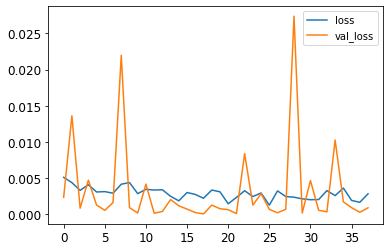

In [20]:

plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
save_fig('vgg16_loss', tight_layout=False)
plt.show()

Saving figure vgg16_accuracy


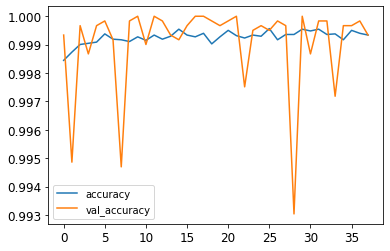

In [21]:
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
save_fig('vgg16_accuracy', tight_layout=False)
plt.show()

Saving figure vgg16_recall


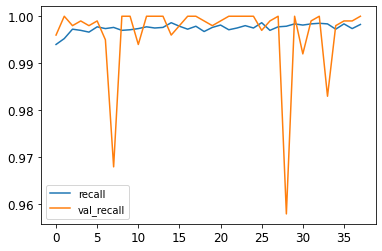

In [22]:
plt.plot(history.epoch, metrics['recall'], metrics['val_recall'])
plt.legend(['recall','val_recall'])
save_fig('vgg16_recall', tight_layout=False)
plt.show()

Saving figure vgg16_precision


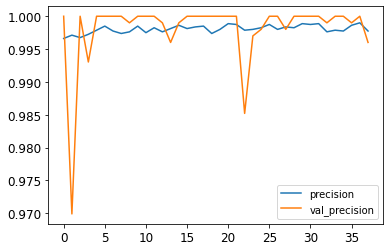

In [23]:
plt.plot(history.epoch, metrics['precision'], metrics['val_precision'])
plt.legend(['precision','val_precision'])
save_fig('vgg16_precision', tight_layout=False)
plt.show()

Saving figure vgg16_auc


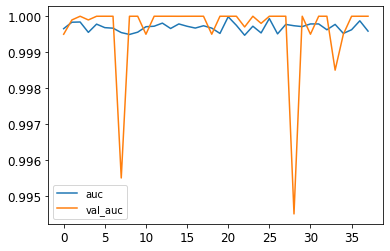

In [24]:
plt.plot(history.epoch, metrics['auc'], metrics['val_auc'])
plt.legend(['auc','val_auc'])
save_fig('vgg16_auc', tight_layout=False)
plt.show()

Saving figure vgg16_all


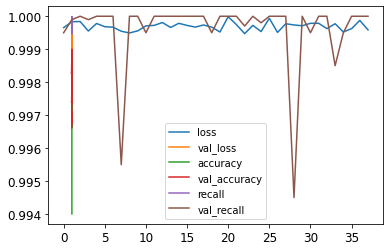

In [25]:
plt.plot(history.epoch, metrics['auc'], metrics['val_auc'],metrics['accuracy'], metrics['val_accuracy'], metrics['recall'], metrics['val_recall'], metrics['precision'], metrics['val_precision'], metrics['auc'], metrics['val_auc'])
plt.legend(['loss','val_loss','accuracy','val_accuracy','recall','val_recall','precision','val_precision','auc','val_auc'])
save_fig('vgg16_all', tight_layout=False)
plt.show()

# Evaluation of the model on the test set

In [26]:
loss, accuracy, recall, precision, auc = model.evaluate(test_image_gen)

189/189 [==============================] - 22s 116ms/step - loss: 222.2896 - accuracy: 0.2540 - recall: 1.0000 - precision: 0.1819 - auc: 0.5535


In [27]:
# F1 score
f1 = 2 * ((precision * recall) / (precision + recall))

print(f"loss: {loss}, \n"
      f"accuracy: {accuracy}, \n"
      f"recall: {recall}, \n"
      f"precision: {precision}, \n"
      f"auc: {auc}, \n"
      f"F1: {f1}")

loss: 222.28961181640625, 
accuracy: 0.25397613644599915, 
recall: 1.0, 
precision: 0.18186773359775543, 
auc: 0.5535253286361694, 
F1: 0.30776326052007014


# Saving the model to use it for predictions, heatmaps, etc.

In [28]:
save_model(model, 'vgg16', 'saved_models/second_train_step/tuned_params')